## Test Bayesian aggregation framework for binary classification
See [Branson et al 2017](http://openaccess.thecvf.com/content_cvpr_2017/papers/Branson_Lean_Crowdsourcing_Combining_CVPR_2017_paper.pdf).

Similar functionality to SWAP.

In [1]:
import sys
import collections
import numpy as np
import scipy.stats as scistats
import matplotlib
import matplotlib.pyplot as mplplot
%matplotlib inline

In [2]:
sys.path.append('/Users/hughdickinson/Documents/Development/BayesianRetirement')

### Simulator for a responses to a binary classification task
The simulator models the reponses of `numClassifiers` independent volunteers each classifying `numSubjects` independent subjects. Each subject receives is annotated by `numAnnotationsPerSubject` (limited to `numClassifiers`) simulated volunteers drawn randomly from the volunteer pool. Each subject is assigned a prior probablility `trueProb` of the correct task reponse being _True_. Each volunteer is assigned a probability `successProb` of correctly classifying any subject. Both `trueProb` and `successProb` can be either single floating point values (in which case, they apply to all subjects/volunteers) or an array like object with length `numClassifiers` or `numSubjects`, assigning an independent probability to each classifier or subject, respectively.

In [3]:
from IO import BinarySimulationReceiver

#### Generate simulated subjects and annotations

In [4]:
numClassifiers=200
numSubjects=1000
numAnnotationsPerSubject=50

trueProb = np.random.uniform(low=0.6, high=1.0, size=numSubjects)
successProb = np.random.uniform(low=0.1, high=0.9, size=numClassifiers)

testSim = BinarySimulationReceiver(
    numClassifiers=numClassifiers,
    numSubjects=numSubjects,
    numAnnotationsPerSubject=numAnnotationsPerSubject,
    trueProb=trueProb,
    successProb=successProb)

testSubjects = testSim.genSubjects()
testSubjectLabels = np.array([subject.trueLabel for subject in testSubjects.items()])

#### Plot simulation results

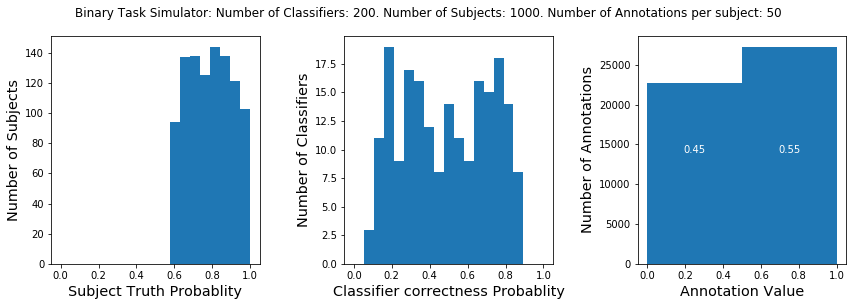

In [5]:
testFigure, testSubplots = mplplot.subplots(figsize=(12,4), ncols=3, nrows=1) 
testSubplots.flatten()[0].hist(trueProb, bins=np.linspace(0, 1, 20))
testSubplots.flatten()[0].set_xlabel('Subject Truth Probablity', fontsize='x-large')
testSubplots.flatten()[0].set_ylabel('Number of Subjects', fontsize='x-large')
testSubplots.flatten()[1].hist(successProb, bins=np.linspace(0, 1, 20))
testSubplots.flatten()[1].set_xlabel('Classifier correctness Probablity', fontsize='x-large')
testSubplots.flatten()[1].set_ylabel('Number of Classifiers', fontsize='x-large')
testSubjects.plotAnnotations(testSubplots.flatten()[2])
testFigure.suptitle('Binary Task Simulator: Number of Classifiers: {}. Number of Subjects: {}. Number of Annotations per subject: {}'.format(numClassifiers, numSubjects, numAnnotationsPerSubject), y=1.05)

mplplot.tight_layout()

### Test aggregation engine using simulated data

In [6]:
from Classifiers import Classifiers
from AnnotationModels import AnnotationModelBinary, AnnotationPriorBinary
from Risk import LossModelBinary, Risk

In [ ]:
knownClassifiers = Classifiers([
    annotation.classifier for annotation in testSubjects.annotations.items()
])
for classifier in knownClassifiers.items():
    classifier.computeSkills(testSubjects)

In [ ]:
annotationModel = AnnotationModelBinary()
annotationPriorModel = AnnotationPriorBinary()
lossModel = LossModelBinary(
    falsePosLoss=1, falseNegLoss=1)

In [ ]:
for subject in testSubjects.items():
    subject.computeTrueLabel(
        annotationModel=annotationModel,
        annotationPriorModel=annotationPriorModel)

In [ ]:
riskEvaluator = Risk()
risks = np.array([riskEvaluator(
        annotations=subject.annotations,
        subject=subject,
        lossModel=lossModel,
        annotationModel=annotationModel,
        annotationPriorModel=annotationPriorModel) for subject in testSubjects.items()])
mplplot.hist(risks, bins=200)
riskThreshold = np.percentile(risks, np.linspace(0, 100, num=9, endpoint=True))[3]
mplplot.gca().axvline(x=riskThreshold, c='r', ls='--', label='Risk Threshold = {}'.format(riskThreshold))
mplplot.gca().legend()

In [ ]:
riskThreshold = np.percentile(risks, np.linspace(0, 100, num=9, endpoint=True))[3]
subjectLabels = np.array([subject.trueLabel for subject in testSubjects.items()])
estTrueCount = subjectLabels.sum()
estFalseCount = (~subjectLabels).sum()
trueCount = testSubjectLabels.sum()
falseCount = (~testSubjectLabels).sum()
subjectLabelAxes = mplplot.figure(figsize=(8,8)).add_subplot(1,1,1)

intSubjectLabels = np.array([0.75 if label else 0.25 for label in subjectLabels])
intTestSubjectLabels = np.array([0.75 if label else 0.25 for label in testSubjectLabels])

binSpec = np.linspace(0, 1, num=3, endpoint=True)

# subjectLabelAxes.hist(intSubjectLabels[risks < riskThreshold], bins=binSpec, label='Recovered Labels (Risk < {:.2f})'.format(riskThreshold), histtype='step', lw=2)
# subjectLabelAxes.hist(intTestSubjectLabels[risks < riskThreshold], bins=binSpec, label='Input Labels (Risk < {:.2f})'.format(riskThreshold), histtype='step', lw=2, ls='--')
# subjectLabelAxes.hist(intSubjectLabels, bins=binSpec, label='Recovered Labels', histtype='step', lw=2)
# subjectLabelAxes.hist(intTestSubjectLabels, bins=binSpec, label='Input Labels', histtype='step', lw=2, ls='--')
# subjectLabelAxes.scatter(subjectLabels.astype(int), testSubjectLabels.astype(int), label='All')
# subjectLabelAxes.scatter(subjectLabels[risks < riskThreshold].astype(int), testSubjectLabels[risks < riskThreshold].astype(int), label='Risk < {:.2f}'.format(riskThreshold))
subjectLabelAxes.scatter(risks, (testSubjectLabels == subjectLabels).astype(int), label='Recovered == Input')
# subjectLabelAxes.scatter(risks, subjectLabels.astype(int), label='input') 
subjectLabelAxes.set_xlabel('Risk', fontsize='x-large')
subjectLabelAxes.set_ylabel('Label', fontsize='x-large')
subjectLabelAxes.set_xlim(risks.min(), risks.max())

subjectLabelAxes.legend(loc='upper left')